# Kriging
#### Mickey MacKie, Stanford Radio Glaciology

Here we implement simple kriging for a case study on Niohalvfjerds-fjorden using variogram parameters from Variogram_model.ipynb. 

Kriging is a deterministic interpolation algorithm. (will elaborate).



In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geostatspy.geostats as geostats 

import GlacierStats as gs

## Load and plot data

<function matplotlib.pyplot.show(*args, **kw)>

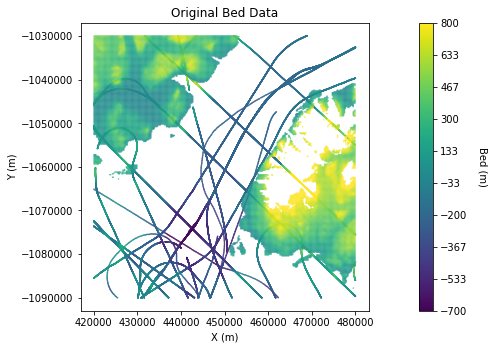

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 800, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Convert to standard Gaussian distribution

In [3]:
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed')  # normal score transformation

## Set variogram parameters

These are the variogram model parameters we determined in Variogram_model.ipynb:

In [4]:
Azimuth = 22.5 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 2 # variogram structures
vtype = [1,2] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [0.8,0.2] # contribution for each structure. nugget + cc = 1
a_max = [40000,50000] # major range for each structure
a_min = [25000,30000] # minor range for each structure

vario = [Azimuth, nug, nstruct, vtype, cc, a_max, a_min] # save variogram parameters as a list

## Kriging interpolation

First we need to define a grid to interpolate:

In [5]:
# define coordinate grid
xmin = 420000; xmax = 480000              # range of x values
ymin = -1090000; ymax = -1030000     # range of y values
pix = 500  # pixel resolution
Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, pix)

Then we can perform kriging

In [6]:
k = 100 # number of neighboring data points used to estimate a given point
est_SK, var_SK = gs.krige(Pred_grid_xy, df_bed, 'X', 'Y', 'Nbed', k, vario) # estimation and variance

100%|██████████| 14400/14400 [01:00<00:00, 239.26it/s]


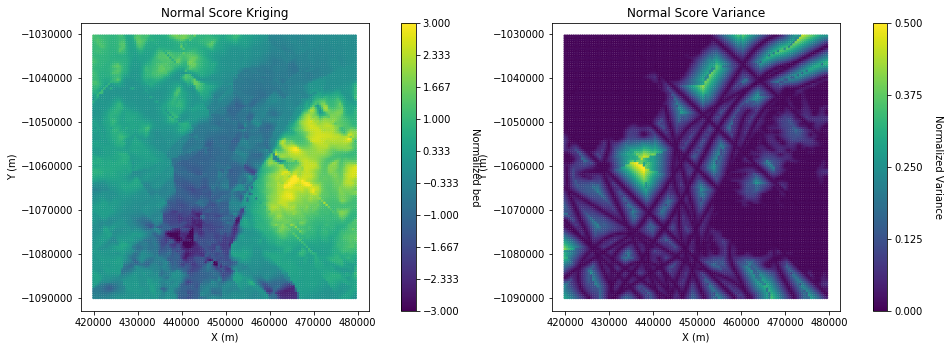

In [7]:
# plot results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = est_SK, vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = var_SK, vmin = 0, vmax = .5, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Variance')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, .5, 5)) # add vertical color bar
cbar.set_label("Normalized Variance", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

The kriging estimate looks a bit choppy. This is mostly due to crossover errors. It could also help to down sample the data or increase the number of data points used to make an estimate (k).

## Reverse normal score transformation

In [8]:
# create dataframes for back transform function
std_SK = np.sqrt(var_SK) # convert to standard deviation (this should be done before back transforming)
df_std = pd.DataFrame(std_SK, columns = ['std'])
df_krige = pd.DataFrame(est_SK, columns = ['pred'])

# transformation parameters
vr = tvbed
vrg = tnsbed
ltail = 1
utail = 1
zmin = -3
zmax = 3
ltpar = -1000
utpar = 1000

# transformation
pred_trans = geostats.backtr(df_krige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)
std_trans = geostats.backtr(df_std,'std',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

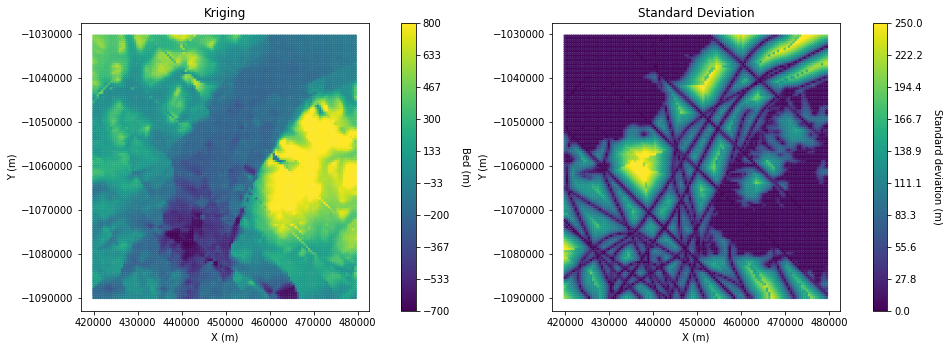

In [9]:
# plot back-transformed results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = pred_trans, vmin = -700, vmax = 800, marker=".", s = 15)       # scatter plot for location map
plt.title('Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122)
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = std_trans, vmin = 0, vmax = 250, marker=".", s = 15)       # scatter plot for location map
plt.title('Standard Deviation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 10)) # add vertical color bar
cbar.set_label("Standard deviation (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

## Spatial statistics

Let's compare the spatial statistics of the data and the kriging interpolation.

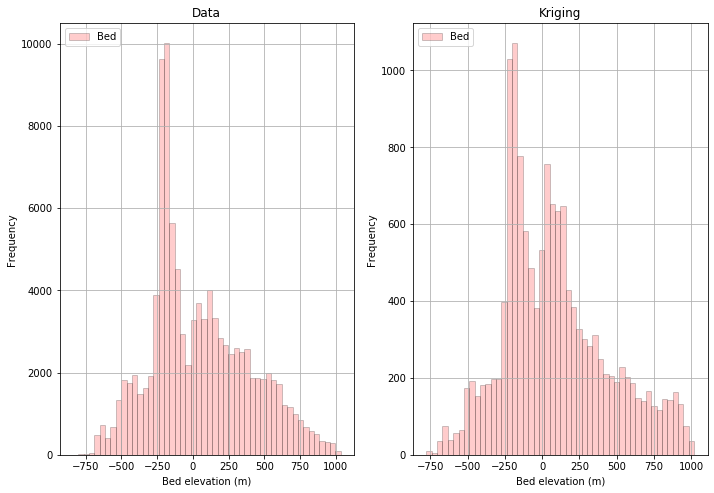

In [160]:
# data histogram
plt.subplot(121)                                    
plt.hist(df_bed['Bed'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Bed elevation (m)'); plt.ylabel('Frequency'); plt.title('Data')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5) # adjust the plot size
plt.grid(True)

# kriging histogram
plt.subplot(122)                                        
plt.hist(pred_trans, facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlabel('Bed elevation (m)'); plt.ylabel('Frequency'); plt.title('Kriging')
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5) # adjust the plot size
plt.grid(True)

In [202]:
# compare variograms

# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=True, random_state=1)

# compute isotropic variogram
tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 2000.0 # lag distance interval (in meters)
lag_tol = 100.0 # lag tolerance
nlag = 20 # number of lag distances to use
bandh = 9999.9 # no effect for isotropic variogram
azi = 0 # azimuth
atol = 90.0 # azimuth tolerance. If atol = 90, the isotropic variogram is calculated
isill = 1 # no effect for normal score transformed data

# data variogram
lag, data_gamma, bed_npair = geostats.gamv(df_samp,"X","Y","Bed",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

# brute force make dataframe for variogram
pred_bed = pd.DataFrame(Pred_grid_xy[:,0], columns = ['X'])
pred_bed['Y'] = pd.DataFrame(Pred_grid_xy[:,1], columns = ['Y'])
pred_bed['Bed'] = pd.DataFrame(pred_trans, columns = ['Bed'])

# kriging variogram
lag, krige_gamma, bed_npair = geostats.gamv(pred_bed,"X","Y","Bed",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

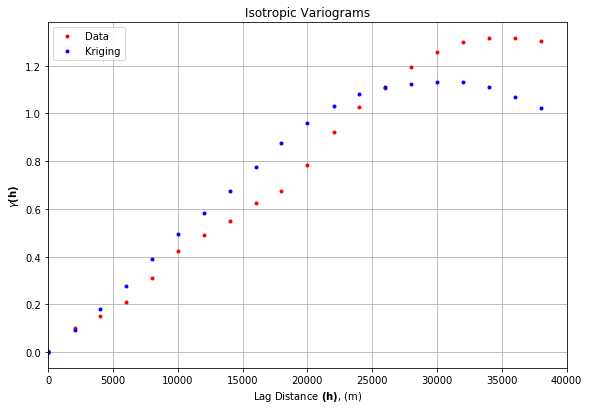

In [203]:
# plot variogram
plt.plot(lag,data_gamma,'.',color = 'red',label = 'Data')
plt.plot(lag,krige_gamma,'.',color = 'blue',label = 'Kriging')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic Variograms')
plt.legend(loc='upper left')
plt.xlim([0,40000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()